<a href="https://colab.research.google.com/github/Bipin-6751/Machine-Learning-Collection/blob/master/xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IMPORTING NECESSARY HEADERS**

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import keras

from keras.layers import Dense, Flatten, Conv2D, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.models import Sequential, Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.inception_v3 import InceptionV3, preprocess_input

**CREATING BASE MODEL FROM ALREADY TRAINED INCEPTION MODEL**

In [15]:
base_model = InceptionV3(input_shape=(256, 256, 3), include_top=False)
for layer in base_model.layers:
  layer.trainable = False

**DEFINING OUR CUSTUM LAYER OUT FROM PRETRAINED MODEL**

In [16]:
x = Flatten()(base_model.output)
x = Dense(units=2, activation='sigmoid')(x)

model = Model(base_model.input, x)

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

**DATA PREPROCESSING METHODS FOR DATASETS**

In [21]:
def train_preprocess(path):
  image_data = ImageDataGenerator(zoom_range=0.2,
                                  shear_range=0.2, 
                                  rescale=1/255, 
                                  horizontal_flip=True,
                                  featurewise_center=True,
                                  rotation_range=0.2,
                                  width_shift_range=0.2,
                                  vertical_flip=True,
                                  preprocessing_function=preprocess_input,
                                  )
  image = image_data.flow_from_directory(directory=path, target_size=(256,256), batch_size=32)
  return image

In [22]:
def test_val_preprocess(path):
  image_data = ImageDataGenerator(preprocessing_function=preprocess_input)
  image = image_data.flow_from_directory(directory=path, target_size=(256,256), batch_size=32)
  return image

**PREPARING THE DATASETS**

In [23]:
train_data = train_preprocess("/content/train")
test_data = test_val_preprocess("/content/test")
val_data = test_val_preprocess("/content/val")

Found 5208 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [24]:
train_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

**MODELING CHECKPOINTS**

In [29]:
mc = ModelCheckpoint(filepath="./best_model.h5",
                     monitor="accuracy",
                     verbose=1,
                     save_best_only=True)
es = EarlyStopping(monitor="accuracy",
                   min_delta=0.01,
                   patience=5,
                   verbose=1)
cb = [mc, es]

In [30]:
batch_size = 64
train_number = 5208
test_number = 624
val_number = 16

history = model.fit_generator(train_data,
                              steps_per_epoch=10, #train_number/batch_size,
                              epochs=10,
                              verbose=1,
                              validation_data=val_data,
                              validation_steps=1,
                              callbacks=cb)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.8750
Epoch 1: accuracy improved from -inf to 0.87500, saving model to ./best_model.h5
10/10 [==============================] - 59s 6s/step - loss: 0.2800 - accuracy: 0.8750 - val_loss: 21.1139 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.8906
Epoch 2: accuracy improved from 0.87500 to 0.89062, saving model to ./best_model.h5
10/10 [==============================] - 57s 6s/step - loss: 0.2677 - accuracy: 0.8906 - val_loss: 21.4883 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8625
Epoch 3: accuracy did not improve from 0.89062
10/10 [==============================] - 57s 6s/step - loss: 0.2841 - accuracy: 0.8625 - val_loss: 23.1171 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.8313
Epoch 4: accuracy did 

**LOADING BEST MODEL FROM CHECKPOINT**

In [31]:
model = load_model("/content/best_model.h5") 

In [32]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

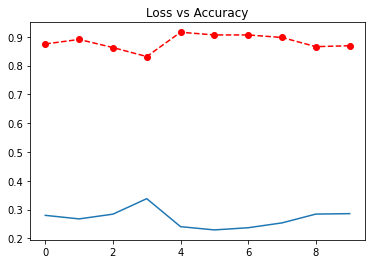

In [33]:
plt.plot(h['loss'])
plt.plot(h['accuracy'], 'go--', c='red')
plt.title("Loss vs Accuracy")
plt.show()

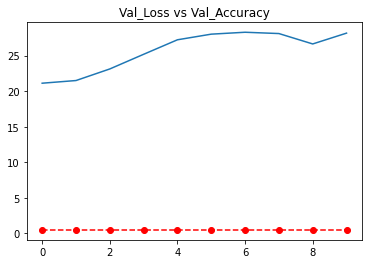

In [34]:
plt.plot(h['val_loss'])
plt.plot(h['val_accuracy'], 'go--', c='red')
plt.title("Val_Loss vs Val_Accuracy")
plt.show()

In [53]:
def get_img_arr(img_path):
  path = img_path
  img = image.load_img(path, target_size=(256, 256))
  img = image.img_to_array(img)
  img = preprocess_input(img)

  img = np.array([img])
  return img

In [54]:
def image_prediction(path):
  img_array = get_img_arr(path)

  pred =  np.argmax(model.predict(preprocess_input(img_array)))

  if pred == 0:
    print("The xray of patient is Normal")
  elif pred == 1:
    print("The patient is Pneumonia Infected")

  a = plt.imread(path)
  plt.imshow(a, cmap='gray')
  plt.title("original image")
  plt.show()

The patient is Pneumonia Infected


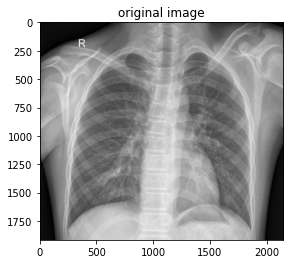

In [55]:
path = "/content/test/NORMAL/IM-0011-0001-0001.jpeg"
image_prediction(path)